# Predicting the Revenue of Hamilton and Other Broadway Shows

## Project Overview
The goal of this project was to predict the gross of the hit Broadway show Hamilton. I web scraped the data from the playbill website and gathered the weekly gross of every Broadway show from 1985. I shortened this data set to only include the show Hamilton and changed the gross column (my target variable) to monthly gross. To clarify, this column is not the sum of all the weekly gross in a month, it is the average of all the weekly grosses for each month.

### Structure of notebook
I run through the notebook while running models to predict the revenue of Hamilton in 2019. Afterwards I go through seven more shows and predict on them using the same models. Since the main goal of the project is to predict Hamilton in 2019, I focus on that show. But, since these functions can be used for many shows I show how those predict too. 

#### Importing

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Series
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.ar_model import AutoReg

## CRISP-DM
For this project, I followed the CRISP-DM approach to make sure that my process was clear, organized and eventually produced the best results. I started with the business understanding which is to make sure that an investor is investing in the show at the right time and knows what the future gross will be. I then looked at the data and only included the rows and columns which would contribute to the model. I down-sampled the data to be monthly and then added exogenous variables later to some of the models. I followed an iterative process for the modeling/evaluation process so I can keep track of all the models that I created and know which ones needed change so they can be improved.  

# 1. HAMILTON

#### Reading in the csv file

In [2]:
df = pd.read_csv('gross.csv')

## Data Preperation
The code was very clean and did not contain any missing values, however, I did change a few things. I down-sampled the data set so its monthly instead of weekly. Additionally, after building some baseline and regular models, I added some exogenous variables to see if that influenced the RMSE. More details to the changes that I made to the data are in the notebook.

#### Selecting the rows and columns that we want

In [3]:
# Only get the rows and columns that we want

# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'Hamilton')]

# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
              'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
              'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 

# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)

# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]')

# Step 5: set the df equal to df_month 
df_month = df

# Step 6: make date the index
df.set_index('date', inplace=True)

#Step 7: Set it equal to 'df_week'
df_week = df

# Step 8: Downsampling to a month
df_month = df.resample('MS').mean()

#Step 9: Look at the final table
df_month.head()

,gross
date,
2015-07-01,1295473.50
2015-08-01,1442194.80
2015-09-01,1592876.75
2015-10-01,1531843.25
2015-11-01,1649660.40


### EDA

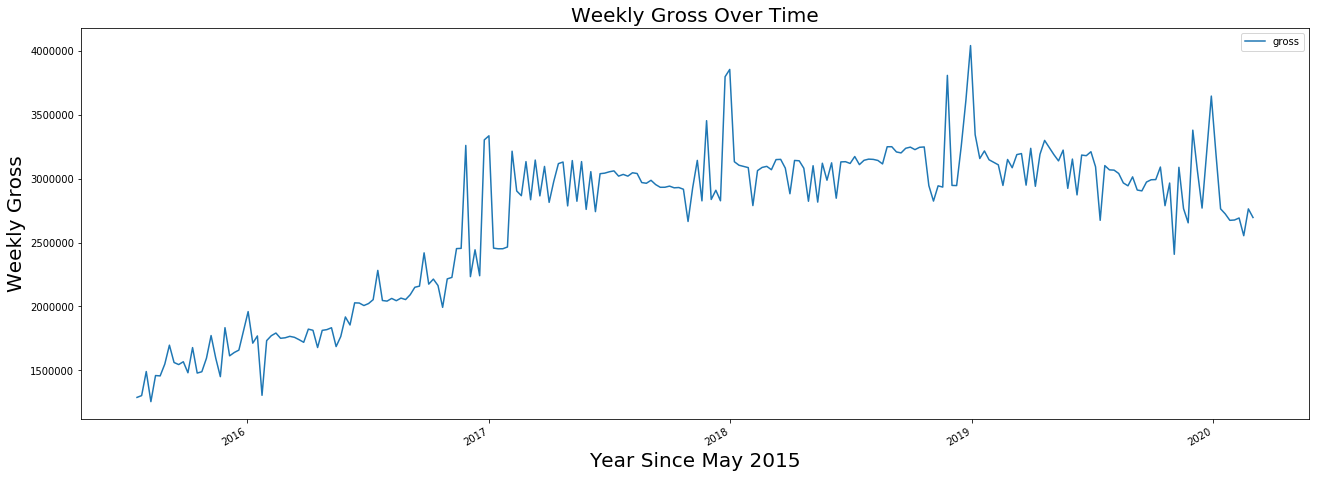

In [4]:
# line plot for week at a time
df.plot(figsize = (22,8))
plt.xlabel('Year Since May 2015', fontsize=20)
plt.ylabel('Weekly Gross', fontsize=20)
plt.title("Weekly Gross Over Time", fontsize=20)
plt.show()

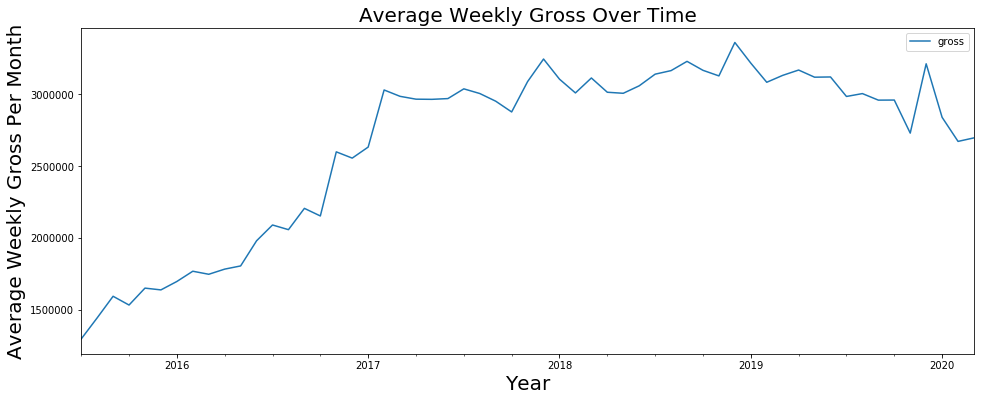

In [5]:
# line plot for a month at a time
df_month.plot(figsize = (16,6));
plt.xlabel('Year', fontsize=20)
plt.ylabel('Average Weekly Gross Per Month', fontsize=20)
plt.title("Average Weekly Gross Over Time", fontsize=20)
plt.show()

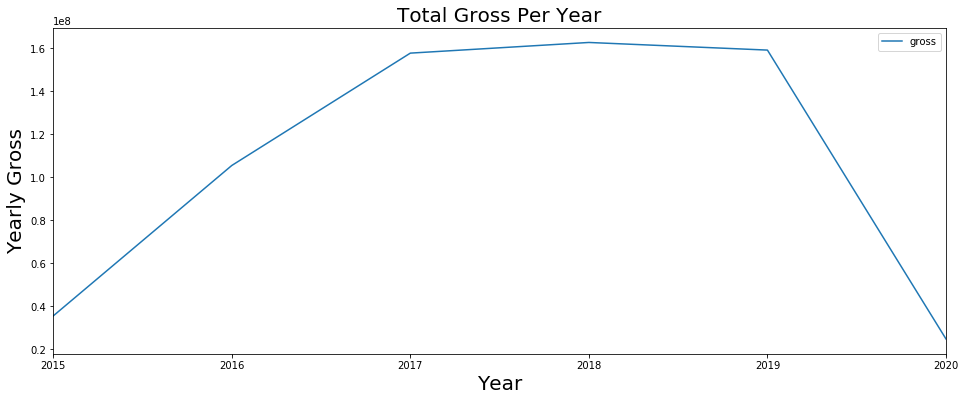

In [6]:
# line plot for a year at a time
df_year = df.resample('A').sum()

df_year.plot(figsize = (16,6));
plt.xlabel('Year', fontsize=20)
plt.ylabel('Yearly Gross', fontsize=20)
plt.title("Total Gross Per Year", fontsize=20)
plt.show()

## Check for Stationarity
In this section of the notebook I use a Dickey-Fuller test to check for stationarity. If there is no stationarity, which there was, then I detrend the data. I do this by taking the square root of the data and then checking again for stationarity. If the p-value is less than the alpha of 0.05 then there is stationarity and I can begin to build my models. 

In [7]:
ts = df_month

# Create a function to check for the stationarity of a given time series using rolling stats and DF test

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['gross'])

    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

stationarity_check(ts)

Results of Dickey-Fuller Test: 

Test Statistic                 -2.481191
p-value                         0.120118
#Lags Used                      2.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


The p-value of .12 is higher than our alpha of .05, therefore we fail to reject the null hypothesis.

In [8]:
# Detrend the data by taking the square root
ts_sqrt = np.sqrt(ts)
stationarity_check(ts_sqrt)

Results of Dickey-Fuller Test: 

Test Statistic                 -2.888194
p-value                         0.046738
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


The p-value of .0467 is lower than our alpha of .05, therefore we reject the null hypothesis and conclude that our date is stationary.

#### Check the ACF and PACF

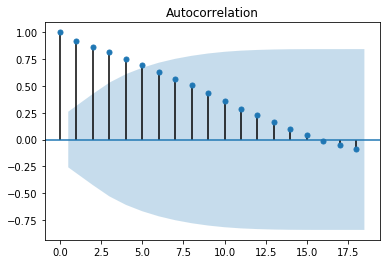

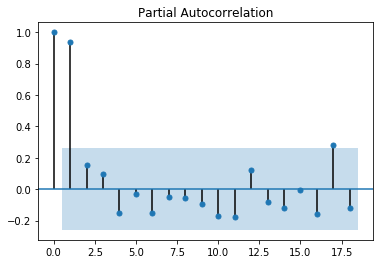

In [9]:
X = ts_sqrt['gross']
alpha=.05
plot_acf(X, alpha=alpha);
plot_pacf(X, alpha=alpha);

Results: 
1. ACF - Strongly positively correlated lags we will use for the MA model
2. PACF - only the first lag is strongly correlated

# Modeling

In [10]:
# To show the scores of all the models throughout the notebook
scores = {}
# the test_start variable corresponds to the first date of the show, 
# which in this case means the beginning of our testing set
test_start = '2015-07-01'
test_end = '2018-12-01'

#### Baseline Model - AR

Test RMSE: $183715.52


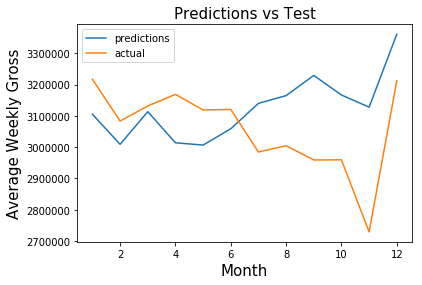

In [11]:
def baseline():
    X = df_month['gross']
    x = X['2018-01-01':'2018-12-01']
    y = X['2019-01-01':'2019-12-01']
    rmse = sqrt(mean_squared_error(x, y))
    print('Test RMSE: $%.2f' % rmse)
    scores['Baseline'] = rmse
    # Print plot 
    plt.plot(range(1, 13), x, label='predictions')
    plt.plot(range(1, 13), y, label='actual')
    plt.xlabel('Month', fontsize=15)
    plt.ylabel('Average Weekly Gross', fontsize=15)
    plt.title("Predictions vs Test", fontsize=15)
    plt.legend()
    plt.show()
        
baseline()

#### ARIMA

When a data set has no seasonality, there is strong dependence among values, and it is non-stationary then we use an ARIMA model. I detrended the data by taking the square root, performed a DIckey-Fuller Test to check the stationarity, and then used an ARIMA model as my baseline to see how it predicts. 

In [12]:
# Full Arima model which prints out the predicted and actual scores of 2019
def build_arima_full(p,d,q):
    X = ts_sqrt['gross']
    train, test = X['2015-07-01':'2018-12-01'], X['2019-01-01':'2019-12-01']
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('Month = %.0f-2019, predicted = $%.2f, expected = $%.2f' % (t+1, yhat**2, obs**2))
    rmse = sqrt(mean_squared_error(test**2, np.array(predictions)**2))
    print('Test RMSE: $%.2f' % rmse)
    scores['Baseline ARIMA', (p,d,q)] = rmse
    scores

In [13]:
# Just prints out the RMSE of the test set
def build_arima(p,d,q):
    X = ts_sqrt['gross']
    train, test = X['2015-07-01':'2018-12-01'], X['2019-01-01':'2019-12-01']
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test**2, np.array(predictions)**2))
    print('pdq =',p,d,q)
    print('Test RMSE: $%.2f' % rmse)
    scores['ARIMA ', (p,d,q)] = rmse
    scores

In [14]:
# Building all the baseline models
build_arima(0,0,0)
build_arima(0,0,1)
build_arima(0,0,2)
build_arima(0,1,0)
build_arima(0,1,1)
build_arima(0,1,2)
print('- - - - - - - -')
build_arima(1,0,0)
build_arima(1,0,1)
build_arima(1,0,2)
build_arima(1,1,0)
build_arima(1,1,1)
print('- - - - - - - -')
build_arima(2,0,0)
build_arima(2,0,1)
build_arima(2,0,2)
build_arima(2,1,0)
build_arima(2,1,1)

pdq = 0 0 0
Test RMSE: $517814.16
pdq = 0 0 1
Test RMSE: $336855.87
pdq = 0 0 2
Test RMSE: $252381.19
pdq = 0 1 0
Test RMSE: $184765.90
pdq = 0 1 1
Test RMSE: $183121.22
pdq = 0 1 2
Test RMSE: $182465.87
- - - - - - - -
pdq = 1 0 0
Test RMSE: $170362.10
pdq = 1 0 1
Test RMSE: $168120.66
pdq = 1 0 2
Test RMSE: $167063.14
pdq = 1 1 0
Test RMSE: $182513.50
pdq = 1 1 1
Test RMSE: $183165.59
- - - - - - - -
pdq = 2 0 0
Test RMSE: $167808.39


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq = 2 0 1
Test RMSE: $163825.46


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq = 2 0 2
Test RMSE: $159722.93
pdq = 2 1 0
Test RMSE: $184693.80
pdq = 2 1 1
Test RMSE: $189559.22


In [15]:
# Showing a list of all the baseline models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Baseline models'
s.sort_values(by = 'RMSE')

,RMSE
Baseline models,
"(ARIMA , (2, 0, 2))",159722.929186
"(ARIMA , (2, 0, 1))",163825.463853
"(ARIMA , (1, 0, 2))",167063.138313
"(ARIMA , (2, 0, 0))",167808.389732
"(ARIMA , (1, 0, 1))",168120.660606
"(ARIMA , (1, 0, 0))",170362.103437
"(ARIMA , (0, 1, 2))",182465.867512
"(ARIMA , (1, 1, 0))",182513.500994
"(ARIMA , (0, 1, 1))",183121.223955


In [16]:
X = df_month['gross']
train, test = X['2015-07-01':'2018-12-01'], X['2019-01-01':'2019-12-01']
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('pdq =',2,0,2)
print('Test RMSE: $%.2f' % rmse)

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian fail

pdq = 2 0 2
Test RMSE: $160896.05


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The baseline model with the parameters (2,0,2) performed the best with an RMSE of 160000

#### SARIMA Models - Parameter Selection

Because there are seasonal patterns in the date set from the spikes in December for holiday season, I decided to use a SARIMA model which takes seasonality into account. For this model I used the original monthly data set which was not detrended. Using the SARIMA model I performed a grid search to find the besyt hyper-parameters. 

In [17]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1821.3630964057124
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1409.4467114993745
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1298.0956206910537
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =2932.491986077116
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1321.8832745705633
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1275.0421645462955
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =935.9236620670023
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =2900.5618325007467
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1752.2930391633147
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1467.1502926411915
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1241.0528787270923
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =2908.7559410094036
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1425.3949256340998
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1363.9538670393385
ARIMA (0

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           833.186
Name: 54, dtype: object

The output of our code suggests that ARIMA(1, 1, 0)x(1, 1, 0, 12) yields the lowest AIC value of 833.186. We should therefore consider this to be optimal option out of all the models we have considered.

In [18]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = SARIMAX(df_month, 
                                        order=(1, 1, 0), 
                                        seasonal_order=(1, 1, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2727      0.215     -1.268      0.205      -0.694       0.149
ar.S.L12      -0.2285      0.135     -1.691      0.091      -0.493       0.036
sigma2      2.345e+10   3.55e-12   6.61e+21      0.000    2.35e+10    2.35e+10


In [19]:
def sarima(test_start, test_end, p,d,q,P,D,Q,m):
    X = df_month['gross']
    train, test = X[test_start:test_end], X['2019-01-01':'2019-12-01']
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=(p,d,q),  seasonal_order=(P,D,Q,m))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('Month = %.0f-2019, predicted = $%.2f, expected = $%.2f' % (t+1, yhat, obs))
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: $%.2f' % rmse)
    scores['SARIMA FROM GS', (p,d,q,P,D,Q,m)] = rmse
    
    plt.plot(range(1, 13), predictions, label='predictions')
    plt.plot(range(1, 13), test, label='actual')
    plt.xlabel('Month', fontsize=15)
    plt.ylabel('Average Weekly Gross', fontsize=15)
    plt.title("Predictions vs Test", fontsize=15)
    plt.legend()
    plt.show()

Month = 1-2019, predicted = $3242174.94, expected = $3216767.25
Month = 2-2019, predicted = $3154521.64, expected = $3083388.25
Month = 3-2019, predicted = $3175148.37, expected = $3131449.50
Month = 4-2019, predicted = $3033681.68, expected = $3168584.75
Month = 5-2019, predicted = $3169863.38, expected = $3118766.25
Month = 6-2019, predicted = $3165342.14, expected = $3120375.40
Month = 7-2019, predicted = $3197752.68, expected = $2984510.75
Month = 8-2019, predicted = $2991587.97, expected = $3004554.00
Month = 9-2019, predicted = $3061219.26, expected = $2958985.20
Month = 10-2019, predicted = $2889225.39, expected = $2959574.75
Month = 11-2019, predicted = $2942202.03, expected = $2729291.50
Month = 12-2019, predicted = $2947516.71, expected = $3212040.40
Test RMSE: $131273.13


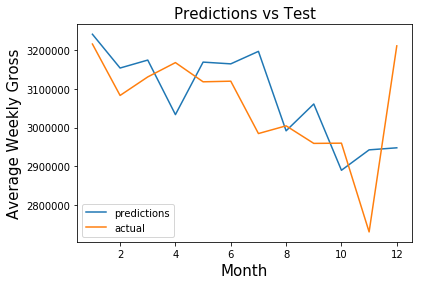

In [20]:
sarima(test_start, test_end, 1,1,0,1,1,0,12)

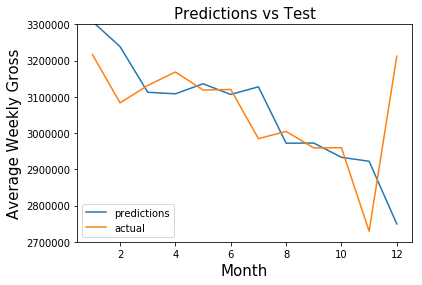

In [21]:
plt.plot(range(1, 13), predictions, label='predictions')
plt.plot(range(1, 13), test, label='actual')
plt.xlabel('Month', fontsize=15)
plt.ylabel('Average Weekly Gross', fontsize=15)
plt.ylim(2700000,3300000)
plt.title("Predictions vs Test", fontsize=15)
plt.legend()
plt.show()

This plot shows my predicted scores in blue and the actual scores in orange

In [22]:
# Updating the list of all the models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

,RMSE
Models,
"(SARIMA FROM GS, (1, 1, 0, 1, 1, 0, 12))",131273.129736
"(ARIMA , (2, 0, 2))",159722.929186
"(ARIMA , (2, 0, 1))",163825.463853
"(ARIMA , (1, 0, 2))",167063.138313
"(ARIMA , (2, 0, 0))",167808.389732
"(ARIMA , (1, 0, 1))",168120.660606
"(ARIMA , (1, 0, 0))",170362.103437
"(ARIMA , (0, 1, 2))",182465.867512
"(ARIMA , (1, 1, 0))",182513.500994


We can see that the SARIMA grid search model performed the best of all the models with an RMSE of 131273

### Adding exogenous variables

I created a few exogenous variables to try and improve my model. In the end, these exognenous variables did not beat my grid search SARIMA RMSE, but they still did perform well. In this cell I will go through the four exogenous variables which I added.
1. Month - I simply created the month of the year as an exog variable to see if that had an effect on the gross of the show
2. I made another variable called season which contains the season of the year
3. I made a yes or no column which contains yes if there is a holiday in that month
4. I made a yes or no column which contains yes if its Christmas month
5. I created another yes or no column which says yes if Lin-Manuel Miranda, the star and writer of the show, is in the show. He was only in the show for the first 13 months
6. I made a yes or no column which contains yes if its December or January

In [23]:
# Create a new df for the exog variables 
df_month_exog = df_month.copy()

Exog variable 1:

In [24]:
df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)

Exog variable 2: 

In [25]:
# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

Exog variable 3:

In [26]:
## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

Exog variable 4:

In [27]:
## add whether or not its December / Christmas month
df_month_exog['Xmas'] = ' '
df_month_exog['Xmas'] = np.where((df_month_exog['month'] == 12), 'Yes', df_month_exog['Xmas'])

Exog variable 5:

In [28]:
# add whether or not Lin-Manuel Miranda is in the show (pre Aug 2016)
df_month_exog.reset_index(inplace=True)
df_month_exog['Lin'] = ' '
df_month_exog['Lin'] = np.where((df_month_exog['date'] < '2016-08-01'), 'Yes', df_month_exog['Lin'])
df_month_exog.set_index('date', inplace=True)

Exog variable 6: 

In [29]:
## add whether or not it is Dec or Jan
df_month_exog['big_holiday'] = ' '
df_month_exog['big_holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['big_holiday'])

In [30]:
# Create dummies
dummies = ['season', 'month', 'holiday', 'Lin', 'big_holiday', 'Xmas']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )
df_month_exog.shape

(57, 19)

In [31]:
# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')

In [32]:
def sarimax(test_start, test_end, p,d,q,P,D,Q,m):
    X = df_month['gross']
    train, test = X[test_start:test_end], X['2019-01-01':'2019-12-01']
    history = [x for x in train]
    predictions = list()
    model = SARIMAX(train, exog=df_month_exog[test_start:test_end], order=(p,d,q),  seasonal_order=(P,D,Q,m))
    model_fit = model.fit(disp=0)
    output = model_fit.predict('2019-01-01', '2019-12-01', exog=df_month_exog['2019-01-01':'2019-12-01'])
    yhat = output[0]
    obs = test[t]
    history.append(obs)
    rmse = sqrt(mean_squared_error(test, output))
    # print('pdq - abce =',p,d,q,a,b,c,e)
    # print('Test RMSE: $%.2f' % rmse)
    scores['SARIMAX ', (p,d,q,P,D,Q,m)] = rmse

In [33]:
# Building all the sarimax models
sarimax(test_start, test_end,0,0,1, 0,0,1, 12)
sarimax(test_start, test_end,0,1,0, 0,1,0, 12)
sarimax(test_start, test_end,1,0,0, 1,0,0, 12)
sarimax(test_start, test_end,1,0,1, 1,0,1, 12)
sarimax(test_start, test_end,1,1,0, 1,1,0, 12)
sarimax(test_start, test_end,2,0,0, 2,0,0, 12)
sarimax(test_start, test_end,2,0,1, 2,0,1, 12)
sarimax(test_start, test_end,2,1,0, 2,1,0, 12)
sarimax(test_start, test_end,0,0,1, 0,0,1, 9)
sarimax(test_start, test_end,0,1,0, 0,1,0, 9)
sarimax(test_start, test_end,1,0,0, 1,0,0, 9)
sarimax(test_start, test_end,1,0,1, 1,0,1, 9)
sarimax(test_start, test_end,1,1,0, 1,1,0, 9)
sarimax(test_start, test_end,2,0,0, 2,0,0, 9)
sarimax(test_start, test_end,2,0,1, 2,0,1, 9)
sarimax(test_start, test_end,2,1,0, 2,1,0, 9)
sarimax(test_start, test_end,0,0,1, 0,0,1, 6)
sarimax(test_start, test_end,0,1,0, 0,1,0, 6)
sarimax(test_start, test_end,1,0,0, 1,0,0, 6)
sarimax(test_start, test_end,1,0,1, 1,0,1, 6)
sarimax(test_start, test_end,1,1,0, 1,1,0, 6)
sarimax(test_start, test_end,2,0,0, 2,0,0, 6)
sarimax(test_start, test_end,2,0,1, 2,0,1, 6)
sarimax(test_start, test_end,2,1,0, 2,1,0, 6)
sarimax(test_start, test_end,0,0,1, 0,0,1, 3)
sarimax(test_start, test_end,0,1,0, 0,1,0, 12)
sarimax(test_start, test_end,1,0,0, 1,0,0, 3)
sarimax(test_start, test_end,1,0,1, 1,0,1, 3)
sarimax(test_start, test_end,1,1,0, 1,1,0, 3)
sarimax(test_start, test_end,2,0,0, 2,0,0, 3)
sarimax(test_start, test_end,2,0,1, 2,0,1, 3)
sarimax(test_start, test_end,2,1,0, 2,1,0, 3)

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

In [34]:
# Updating the list of all the models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

,RMSE
Models,
"(SARIMA FROM GS, (1, 1, 0, 1, 1, 0, 12))",131273.129736
"(SARIMAX , (1, 0, 0, 1, 0, 0, 9))",134413.173360
"(SARIMAX , (2, 0, 0, 2, 0, 0, 3))",139575.629923
"(SARIMAX , (1, 0, 0, 1, 0, 0, 3))",141279.727361
"(SARIMAX , (1, 0, 0, 1, 0, 0, 6))",146461.183112
"(SARIMAX , (0, 0, 1, 0, 0, 1, 9))",152536.690586
"(SARIMAX , (0, 0, 1, 0, 0, 1, 3))",152758.590304
"(ARIMA , (2, 0, 2))",159722.929186
"(SARIMAX , (2, 0, 1, 2, 0, 1, 3))",162852.739919


# 2. WICKED

In [35]:
# Read in the df
df = pd.read_csv('gross.csv')
# Only get the rows and columns that we want
# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'Wicked')]
# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
          'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
          'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 
# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)
# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]') 
# Step 5: set the df equal to df_month 
df_month = df
# Step 6: make date the index
df.set_index('date', inplace=True)
# Step 8: Downsampling to a month
df_month = df.resample('MS').mean()
#Step 9: Look at the final table
df_month.head()

,gross
date,
2003-10-01,7.387043e+05
2003-11-01,9.251442e+05
2003-12-01,1.064908e+06
2004-01-01,1.056137e+06
2004-02-01,9.946004e+05


In [36]:
# To show the scores of all the models throughout the notebook
scores = {}
# the test_start variable corresponds to the first date of the show, 
# which in this case means the beginning of our testing set
test_start = '2003-10-01'
test_end = '2018-12-01'

#### Baseline Model - AR

Test RMSE: $123771.94


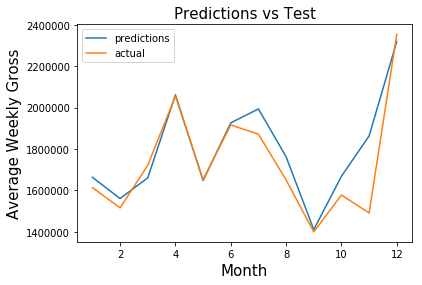

In [37]:
baseline()

#### SARIMA Models - Parameter Selection

In [38]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            # print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           4553.92
Name: 27, dtype: object


Month = 1-2019, predicted = $1919503.91, expected = $1613703.00
Month = 2-2019, predicted = $1563190.53, expected = $1515574.75
Month = 3-2019, predicted = $1703486.40, expected = $1721354.40
Month = 4-2019, predicted = $1975354.51, expected = $2055993.75
Month = 5-2019, predicted = $1681120.69, expected = $1652713.50
Month = 6-2019, predicted = $1925262.24, expected = $1916287.40
Month = 7-2019, predicted = $1966156.82, expected = $1871582.50
Month = 8-2019, predicted = $1765031.64, expected = $1650545.38
Month = 9-2019, predicted = $1361959.62, expected = $1399544.40
Month = 10-2019, predicted = $1582387.58, expected = $1577894.88
Month = 11-2019, predicted = $1711753.54, expected = $1490854.12
Month = 12-2019, predicted = $2016728.24, expected = $2354405.60
Test RMSE: $155402.08


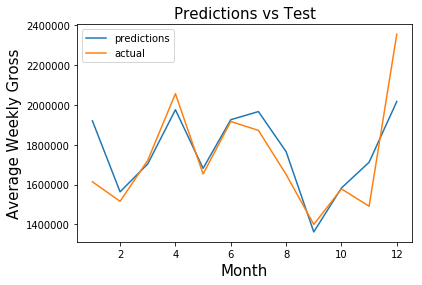

In [39]:
sarima(test_start, test_end, 0,1,1,0,1,1,12)

#### SARIMAX Model (with exogenous variables)

In [40]:
# Create a new df for the exog variables 
df_month_exog = df_month.copy()

df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)

# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

## add whether or not its December / Christmas month
df_month_exog['Xmas'] = ' '
df_month_exog['Xmas'] = np.where((df_month_exog['month'] == 12), 'Yes', df_month_exog['Xmas'])

## add whether or not it is Dec or Jan
df_month_exog['big_holiday'] = ' '
df_month_exog['big_holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['big_holiday'])

# Create dummies
dummies = ['season', 'month', 'holiday', 'big_holiday', 'Xmas']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )

# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')

In [41]:
# Building all the sarimax models
sarimax(test_start, test_end, 0,0,1, 0,0,1, 12)
sarimax(test_start, test_end, 0,1,0, 0,1,0, 12)
sarimax(test_start, test_end, 1,0,0, 1,0,0, 12)
sarimax(test_start, test_end, 1,0,1, 1,0,1, 12)
sarimax(test_start, test_end, 1,1,0, 1,1,0, 12)
sarimax(test_start, test_end, 2,0,0, 2,0,0, 12)
sarimax(test_start, test_end, 2,0,1, 2,0,1, 12)
sarimax(test_start, test_end, 2,1,0, 2,1,0, 12)

# Updating the list of all the models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

,RMSE
Models,
Baseline,123771.935653
"(SARIMAX , (1, 0, 0, 1, 0, 0, 12))",151163.713832
"(SARIMA FROM GS, (0, 1, 1, 0, 1, 1, 12))",155402.081310
"(SARIMAX , (0, 0, 1, 0, 0, 1, 12))",158358.103284
"(SARIMAX , (2, 0, 0, 2, 0, 0, 12))",166900.151509
"(SARIMAX , (0, 1, 0, 0, 1, 0, 12))",169982.944238
"(SARIMAX , (2, 0, 1, 2, 0, 1, 12))",170650.019336
"(SARIMAX , (1, 0, 1, 1, 0, 1, 12))",174402.580102
"(SARIMAX , (1, 1, 0, 1, 1, 0, 12))",242160.367488


# 3. CHICAGO

In [42]:
# Read in the df
df = pd.read_csv('gross.csv')
# Only get the rows and columns that we want
# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'Chicago')]
# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
          'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
          'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 
# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)
# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]') 
# Step 5: set the df equal to df_month 
df_month = df
# Step 6: make date the index
df.set_index('date', inplace=True)
# Step 8: Downsampling to a month
df_month = df.resample('MS').mean()
#Step 9: Look at the final table
df_month.head()

,gross
date,
1996-10-01,281962.0
1996-11-01,457553.0
1996-12-01,624339.0
1997-01-01,645589.5
1997-02-01,574825.5


In [43]:
# To show the scores of all the models throughout the notebook
scores = {}
# the test_start variable corresponds to the first date of the show, 
# which in this case means the beginning of our testing set
test_start = '1996-10-01'
test_end = '2018-12-01'

#### Baseline Model - AR

Test RMSE: $71260.02


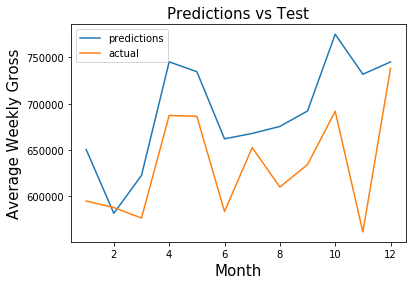

In [44]:
baseline()

#### SARIMA Models - Parameter Selection

In [45]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            # print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           6355.75
Name: 27, dtype: object

Month = 1-2019, predicted = $765968.55, expected = $594964.45
Month = 2-2019, predicted = $559915.62, expected = $587888.46
Month = 3-2019, predicted = $640926.38, expected = $576565.89
Month = 4-2019, predicted = $659607.82, expected = $687358.57
Month = 5-2019, predicted = $669891.48, expected = $686388.22
Month = 6-2019, predicted = $638913.83, expected = $583623.83
Month = 7-2019, predicted = $633565.88, expected = $652619.11
Month = 8-2019, predicted = $637439.45, expected = $610023.22
Month = 9-2019, predicted = $612819.71, expected = $634324.75
Month = 10-2019, predicted = $670548.12, expected = $691853.22
Month = 11-2019, predicted = $617243.53, expected = $561584.91
Month = 12-2019, predicted = $635697.25, expected = $738242.88
Test RMSE: $67026.69


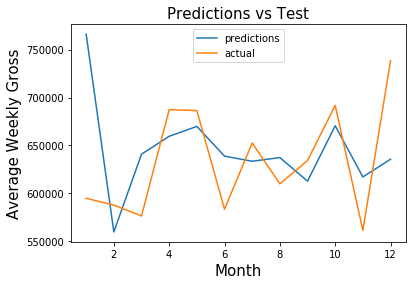

In [46]:
sarima(test_start, test_end, 0,1,1,0,1,1,12)

#### SARIMAX Model (with exogenous variables)

In [47]:
# Create a new df for the exog variables 
df_month_exog = df_month.copy()

df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)

# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

## add whether or not its December / Christmas month
df_month_exog['Xmas'] = ' '
df_month_exog['Xmas'] = np.where((df_month_exog['month'] == 12), 'Yes', df_month_exog['Xmas'])

## add whether or not it is Dec or Jan
df_month_exog['big_holiday'] = ' '
df_month_exog['big_holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['big_holiday'])

# Create dummies
dummies = ['season', 'month', 'holiday', 'big_holiday', 'Xmas']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )

# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')
    
# Building all the sarimax models
sarimax(test_start, test_end, 0,0,1, 0,0,1, 12)
sarimax(test_start, test_end, 0,1,0, 0,1,0, 12)
sarimax(test_start, test_end, 1,0,0, 1,0,0, 12)
sarimax(test_start, test_end, 1,0,1, 1,0,1, 12)
sarimax(test_start, test_end, 1,1,0, 1,1,0, 12)
sarimax(test_start, test_end, 2,0,0, 2,0,0, 12)
sarimax(test_start, test_end, 2,0,1, 2,0,1, 12)
sarimax(test_start, test_end, 2,1,0, 2,1,0, 12)

# Updating the list of all the models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

,RMSE
Models,
"(SARIMAX , (2, 0, 1, 2, 0, 1, 12))",52902.121497
"(SARIMAX , (1, 0, 1, 1, 0, 1, 12))",53370.834403
"(SARIMAX , (2, 0, 0, 2, 0, 0, 12))",54720.990970
"(SARIMAX , (1, 0, 0, 1, 0, 0, 12))",57591.486389
"(SARIMAX , (0, 0, 1, 0, 0, 1, 12))",60214.781012
"(SARIMA FROM GS, (0, 1, 1, 0, 1, 1, 12))",67026.687173
Baseline,71260.024723
"(SARIMAX , (0, 1, 0, 0, 1, 0, 12))",89501.026099
"(SARIMAX , (1, 1, 0, 1, 1, 0, 12))",133786.559278


# 4. COME FROM AWAY

In [48]:
# Read in the df
df = pd.read_csv('gross.csv')
# Only get the rows and columns that we want
# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'Come From Away')]
# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
          'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
          'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 
# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)
# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]') 
# Step 5: set the df equal to df_month 
df_month = df
# Step 6: make date the index
df.set_index('date', inplace=True)
# Step 8: Downsampling to a month
df_month = df.resample('MS').mean()
#Step 9: Look at the final table
df_month.head()

,gross
date,
2017-02-01,462098.390
2017-03-01,773699.355
2017-04-01,1038129.192
2017-05-01,1124317.520
2017-06-01,1189251.000


In [49]:
# To show the scores of all the models throughout the notebook
scores = {}
# the test_start variable corresponds to the first date of the show, 
# which in this case means the beginning of our testing set
test_start = '2017-02-01'
test_end = '2018-12-01'

#### Baseline Model - AR

Test RMSE: $206663.01


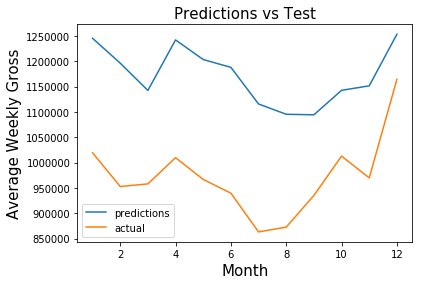

In [50]:
baseline()

#### SARIMA Models - Parameter Selection

In [51]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            # print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           274.238
Name: 27, dtype: object

Month = 1-2019, predicted = $1170786.96, expected = $1019326.11
Month = 2-2019, predicted = $1093379.17, expected = $952740.35
Month = 3-2019, predicted = $938960.95, expected = $957920.35
Month = 4-2019, predicted = $1087994.08, expected = $1009673.88
Month = 5-2019, predicted = $939874.57, expected = $966733.00
Month = 6-2019, predicted = $977619.10, expected = $939564.96
Month = 7-2019, predicted = $868497.08, expected = $863120.77
Month = 8-2019, predicted = $846138.99, expected = $872615.47
Month = 9-2019, predicted = $887747.19, expected = $935094.28
Month = 10-2019, predicted = $1008564.53, expected = $1012763.62
Month = 11-2019, predicted = $1026056.82, expected = $969717.41
Month = 12-2019, predicted = $1031128.84, expected = $1164357.58
Test RMSE: $79212.79


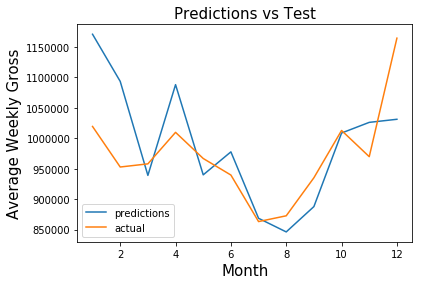

In [52]:
sarima(test_start, test_end, 0,1,1,0,1,1,12)

#### SARIMAX Model (with exogenous variables)

In [53]:
# Create a new df for the exog variables 
df_month_exog = df_month.copy()

df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)

# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

## add whether or not its December / Christmas month
df_month_exog['Xmas'] = ' '
df_month_exog['Xmas'] = np.where((df_month_exog['month'] == 12), 'Yes', df_month_exog['Xmas'])

## add whether or not it is Dec or Jan
df_month_exog['big_holiday'] = ' '
df_month_exog['big_holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['big_holiday'])

# Create dummies
dummies = ['season', 'month', 'holiday', 'big_holiday', 'Xmas']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )

# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')
    
# Building all the sarimax models
sarimax(test_start, test_end, 0,0,1, 0,0,1, 12)
sarimax(test_start, test_end, 0,1,0, 0,1,0, 12)
sarimax(test_start, test_end, 1,0,0, 1,0,0, 12)
sarimax(test_start, test_end, 1,0,1, 1,0,1, 12)
sarimax(test_start, test_end, 1,1,0, 1,1,0, 12)
sarimax(test_start, test_end, 2,0,0, 2,0,0, 12)
sarimax(test_start, test_end, 2,0,1, 2,0,1, 12)
sarimax(test_start, test_end, 2,1,0, 2,1,0, 12)

# Updating the list of all the models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

,RMSE
Models,
"(SARIMAX , (0, 1, 0, 0, 1, 0, 12))",59728.686756
"(SARIMAX , (1, 1, 0, 1, 1, 0, 12))",71341.815742
"(SARIMA FROM GS, (0, 1, 1, 0, 1, 1, 12))",79212.785945
Baseline,206663.014821
"(SARIMAX , (0, 0, 1, 0, 0, 1, 12))",251004.501380
"(SARIMAX , (1, 0, 1, 1, 0, 1, 12))",284600.243967
"(SARIMAX , (2, 0, 1, 2, 0, 1, 12))",284770.798343
"(SARIMAX , (2, 0, 0, 2, 0, 0, 12))",286949.885177
"(SARIMAX , (1, 0, 0, 1, 0, 0, 12))",288458.782443


# 5. DEAR EVAN HANSEN

BASELINE
Test RMSE: $426118.03


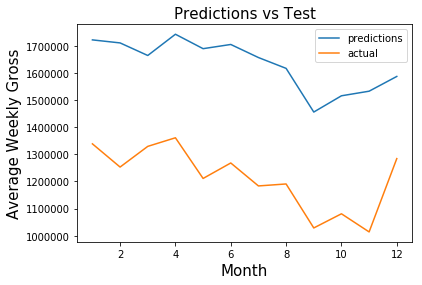

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           367.464
Name: 27, dtype: object
SARIMA
Month = 1-2019, predicted = $1583849.25, expected = $1338941.95
Month = 2-2019, predicted = $1339423.20, expected = $1253278.96
Month = 3-2019, predicted = $1238555.43, expected = $1329651.57
Month = 4-2019, predicted = $1383369.83, expected = $1361376.36
Month = 5-2019, predicted = $1351295.27, expected = $1211200.61
Month = 6-2019, predicted = $1217186.90, expected = $1268352.20
Month = 7-2019, predicted = $1331337.12, expected = $1183591.90
Month = 8-2019, predicted = $1166608.35, expected = $1190880.71
Month = 9-2019, predicted = $1068517.07, expected = $1028441.96
Month = 10-2019, predicted = $1074885.25, expected = $1080759.72
Month = 11-2019, predicted = $1143223.08, expected = $1013825.10
Month = 12-2019, predicted = $1075503.16, expected = $1284465.36
Test RMSE: $123455.25


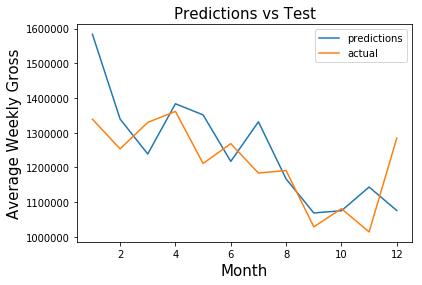

SARIMAX


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

Final Table


,RMSE
Models,
"(SARIMA FROM GS, (0, 1, 1, 0, 1, 1, 12))",123455.254264
"(SARIMAX , (0, 1, 0, 0, 1, 0, 12))",167693.827608
"(SARIMAX , (2, 0, 1, 2, 0, 1, 12))",288102.453505
"(SARIMAX , (0, 0, 1, 0, 0, 1, 12))",314338.163452
"(SARIMAX , (2, 1, 0, 2, 1, 0, 12))",318913.680156
"(SARIMAX , (2, 0, 0, 2, 0, 0, 12))",328189.622234
"(SARIMAX , (1, 1, 0, 1, 1, 0, 12))",343792.515605
"(SARIMAX , (1, 0, 1, 1, 0, 1, 12))",409163.037243
"(SARIMAX , (1, 0, 0, 1, 0, 0, 12))",422509.732816


In [54]:
# Read in the df
df = pd.read_csv('gross.csv')
# Only get the rows and columns that we want
# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'Dear Evan Hansen')]
# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
          'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
          'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 
# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)
# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]') 
# Step 5: set the df equal to df_month 
df_month = df
# Step 6: make date the index
df.set_index('date', inplace=True)
# Step 8: Downsampling to a month
df_month = df.resample('MS').mean()
#Step 9: Look at the final table
df_month.head()

# To show the scores of all the models throughout the notebook
scores = {}
# the test_start variable corresponds to the first date of the show, 
# which in this case means the beginning of our testing set
test_start = '2016-11-01'
test_end = '2018-12-01'

#### Baseline Model - AR

print('BASELINE')
baseline()

#### SARIMA Models - Parameter Selection

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            # print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])

print('SARIMA')
sarima(test_start, test_end, 0,1,1,0,1,1,12)

#### SARIMAX Model (with exogenous variables)

# Create a new df for the exog variables 
df_month_exog = df_month.copy()

df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)

# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

## add whether or not its December / Christmas month
df_month_exog['Xmas'] = ' '
df_month_exog['Xmas'] = np.where((df_month_exog['month'] == 12), 'Yes', df_month_exog['Xmas'])

## add whether or not it is Dec or Jan
df_month_exog['big_holiday'] = ' '
df_month_exog['big_holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['big_holiday'])

# Create dummies
dummies = ['season', 'month', 'holiday', 'big_holiday', 'Xmas']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )

# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')
    
# Building all the sarimax models
print('SARIMAX')
sarimax(test_start, test_end, 0,0,1, 0,0,1, 12)
sarimax(test_start, test_end, 0,1,0, 0,1,0, 12)
sarimax(test_start, test_end, 1,0,0, 1,0,0, 12)
sarimax(test_start, test_end, 1,0,1, 1,0,1, 12)
sarimax(test_start, test_end, 1,1,0, 1,1,0, 12)
sarimax(test_start, test_end, 2,0,0, 2,0,0, 12)
sarimax(test_start, test_end, 2,0,1, 2,0,1, 12)
sarimax(test_start, test_end, 2,1,0, 2,1,0, 12)

# Updating the list of all the models and their RMSE scores
print('Final Table')
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

# 6. Aladdin

BASELINE
Test RMSE: $85402.15


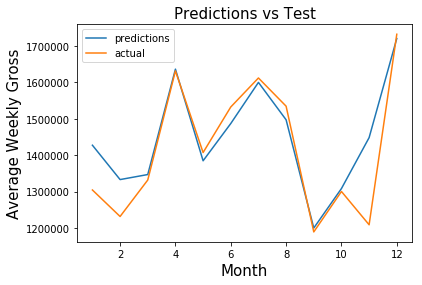

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1186.43
Name: 27, dtype: object
SARIMA
Month = 1-2019, predicted = $1454207.23, expected = $1304325.98
Month = 2-2019, predicted = $1203853.55, expected = $1231490.75
Month = 3-2019, predicted = $1271556.73, expected = $1331743.82
Month = 4-2019, predicted = $1579368.04, expected = $1631616.07
Month = 5-2019, predicted = $1386284.62, expected = $1407280.15
Month = 6-2019, predicted = $1511909.21, expected = $1532494.90
Month = 7-2019, predicted = $1638233.17, expected = $1612229.25
Month = 8-2019, predicted = $1532253.76, expected = $1534686.48
Month = 9-2019, predicted = $1252360.34, expected = $1189089.30
Month = 10-2019, predicted = $1303092.35, expected = $1300240.15
Month = 11-2019, predicted = $1425524.87, expected = $1208703.10
Month = 12-2019, predicted = $1503822.66, expected = $1732443.14
Test RMSE: $105836.99


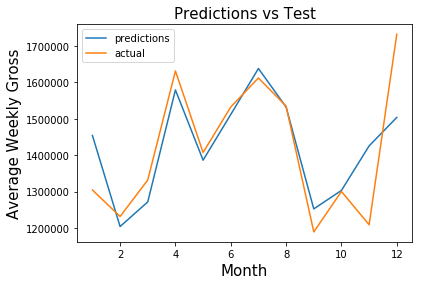

SARIMAX


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

Final Table


,RMSE
Models,
"(SARIMAX , (1, 1, 0, 1, 1, 0, 12))",84380.357211
Baseline,85402.145557
"(SARIMAX , (0, 1, 0, 0, 1, 0, 12))",86528.860883
"(SARIMAX , (2, 1, 0, 2, 1, 0, 12))",91606.932934
"(SARIMA FROM GS, (0, 1, 1, 0, 1, 1, 12))",105836.989449
"(SARIMAX , (2, 0, 0, 2, 0, 0, 12))",132935.848687
"(SARIMAX , (2, 0, 1, 2, 0, 1, 12))",136714.947187
"(SARIMAX , (1, 0, 1, 1, 0, 1, 12))",138170.484636
"(SARIMAX , (1, 0, 0, 1, 0, 0, 12))",141595.785782


In [55]:
# Read in the df
df = pd.read_csv('gross.csv')
# Only get the rows and columns that we want
# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'Aladdin')]
# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
          'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
          'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 
# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)
# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]') 
# Step 5: set the df equal to df_month 
df_month = df
# Step 6: make date the index
df.set_index('date', inplace=True)
# Step 8: Downsampling to a month
df_month = df.resample('MS').mean()
#Step 9: Look at the final table
df_month.head()

# To show the scores of all the models throughout the notebook
scores = {}
# the test_start variable corresponds to the first date of the show, 
# which in this case means the beginning of our testing set
test_start = '2014-03-01'
test_end = '2018-12-01'

#### Baseline Model - AR

print('BASELINE')
baseline()

#### SARIMA Models - Parameter Selection

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            # print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])

print('SARIMA')
sarima(test_start, test_end, 0,1,1,0,1,1,12)

#### SARIMAX Model (with exogenous variables)

# Create a new df for the exog variables 
df_month_exog = df_month.copy()

df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)

# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

## add whether or not its December / Christmas month
df_month_exog['Xmas'] = ' '
df_month_exog['Xmas'] = np.where((df_month_exog['month'] == 12), 'Yes', df_month_exog['Xmas'])

## add whether or not it is Dec or Jan
df_month_exog['big_holiday'] = ' '
df_month_exog['big_holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['big_holiday'])

# Create dummies
dummies = ['season', 'month', 'holiday', 'big_holiday', 'Xmas']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )

# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')
    
# Building all the sarimax models
print('SARIMAX')
sarimax(test_start, test_end, 0,0,1, 0,0,1, 12)
sarimax(test_start, test_end, 0,1,0, 0,1,0, 12)
sarimax(test_start, test_end, 1,0,0, 1,0,0, 12)
sarimax(test_start, test_end, 1,0,1, 1,0,1, 12)
sarimax(test_start, test_end, 1,1,0, 1,1,0, 12)
sarimax(test_start, test_end, 2,0,0, 2,0,0, 12)
sarimax(test_start, test_end, 2,0,1, 2,0,1, 12)
sarimax(test_start, test_end, 2,1,0, 2,1,0, 12)

# Updating the list of all the models and their RMSE scores
print('Final Table')
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

# 7. BOOK OF MORMON

BASELINE
Test RMSE: $104927.23


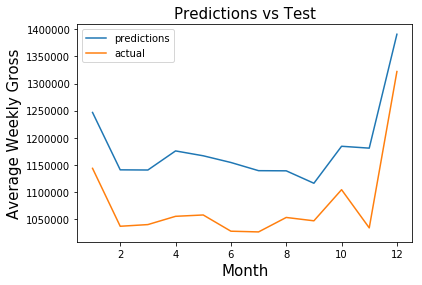

/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           2086.17
Name: 27, dtype: object
SARIMA
Month = 1-2019, predicted = $1270997.43, expected = $1143404.50
Month = 2-2019, predicted = $1013298.91, expected = $1036440.75
Month = 3-2019, predicted = $1027061.48, expected = $1039559.62
Month = 4-2019, predicted = $1058300.66, expected = $1054820.06
Month = 5-2019, predicted = $1049504.90, expected = $1057300.77
Month = 6-2019, predicted = $1046809.99, expected = $1027342.98
Month = 7-2019, predicted = $1029146.50, expected = $1026020.39
Month = 8-2019, predicted = $1006835.56, expected = $1052717.02
Month = 9-2019, predicted = $1025743.05, expected = $1046529.84
Month = 10-2019, predicted = $1102832.30, expected = $1103996.48
Month = 11-2019, predicted = $1116309.33, expected = $1033475.57
Month = 12-2019, predicted = $1224182.34, expected = $1322160.67
Test RMSE: $55100.72


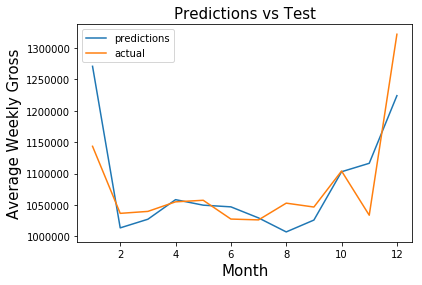

SARIMAX


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

Final Table


,RMSE
Models,
"(SARIMAX , (0, 1, 0, 0, 1, 0, 12))",41813.036470
"(SARIMA FROM GS, (0, 1, 1, 0, 1, 1, 12))",55100.717573
"(SARIMAX , (2, 1, 0, 2, 1, 0, 12))",75721.443824
"(SARIMAX , (1, 1, 0, 1, 1, 0, 12))",77537.104457
Baseline,104927.230921
"(SARIMAX , (2, 0, 1, 2, 0, 1, 12))",113406.054776
"(SARIMAX , (1, 0, 1, 1, 0, 1, 12))",127453.217167
"(SARIMAX , (2, 0, 0, 2, 0, 0, 12))",128984.722008
"(SARIMAX , (1, 0, 0, 1, 0, 0, 12))",153809.856014


In [56]:
# Read in the df
df = pd.read_csv('gross.csv')
# Only get the rows and columns that we want
# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'The Book of Mormon')]
# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
          'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
          'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 
# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)
# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]') 
# Step 5: set the df equal to df_month 
df_month = df
# Step 6: make date the index
df.set_index('date', inplace=True)
# Step 8: Downsampling to a month
df_month = df.resample('MS').mean()
#Step 9: Look at the final table
df_month.head()

# To show the scores of all the models throughout the notebook
scores = {}
# the test_start variable corresponds to the first date of the show, 
# which in this case means the beginning of our testing set
test_start = '2011-02-01'
test_end = '2018-12-01'

#### Baseline Model - AR

print('BASELINE')
baseline()

#### SARIMA Models - Parameter Selection

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            # print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])

print('SARIMA')
sarima(test_start, test_end, 0,1,1,0,1,1,12)

#### SARIMAX Model (with exogenous variables)

# Create a new df for the exog variables 
df_month_exog = df_month.copy()

df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)

# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

## add whether or not its December / Christmas month
df_month_exog['Xmas'] = ' '
df_month_exog['Xmas'] = np.where((df_month_exog['month'] == 12), 'Yes', df_month_exog['Xmas'])

## add whether or not it is Dec or Jan
df_month_exog['big_holiday'] = ' '
df_month_exog['big_holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['big_holiday'])

# Create dummies
dummies = ['season', 'month', 'holiday', 'big_holiday', 'Xmas']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )

# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')
    
# Building all the sarimax models
print('SARIMAX')
sarimax(test_start, test_end, 0,0,1, 0,0,1, 12)
sarimax(test_start, test_end, 0,1,0, 0,1,0, 12)
sarimax(test_start, test_end, 1,0,0, 1,0,0, 12)
sarimax(test_start, test_end, 1,0,1, 1,0,1, 12)
sarimax(test_start, test_end, 1,1,0, 1,1,0, 12)
sarimax(test_start, test_end, 2,0,0, 2,0,0, 12)
sarimax(test_start, test_end, 2,0,1, 2,0,1, 12)
sarimax(test_start, test_end, 2,1,0, 2,1,0, 12)

# Updating the list of all the models and their RMSE scores
print('Final Table')
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

# 8. LION KING

BASELINE
Test RMSE: $148320.03


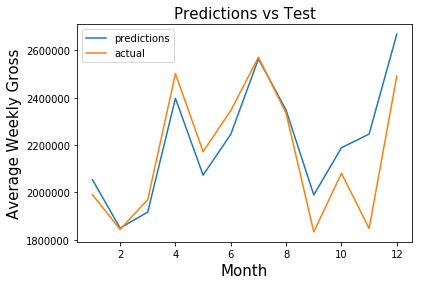

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           6314.09
Name: 27, dtype: object
SARIMA
Month = 1-2019, predicted = $2295490.82, expected = $1990435.50
Month = 2-2019, predicted = $1925850.00, expected = $1843952.75
Month = 3-2019, predicted = $2016457.41, expected = $1970016.10
Month = 4-2019, predicted = $2378235.16, expected = $2501658.00
Month = 5-2019, predicted = $2171452.98, expected = $2172321.75
Month = 6-2019, predicted = $2334709.91, expected = $2345747.00
Month = 7-2019, predicted = $2635910.40, expected = $2571134.25
Month = 8-2019, predicted = $2402290.72, expected = $2334087.25
Month = 9-2019, predicted = $2021354.73, expected = $1833340.20
Month = 10-2019, predicted = $2125247.97, expected = $2081121.50
Month = 11-2019, predicted = $2103786.23, expected = $1848087.00
Month = 12-2019, predicted = $2371229.39, expected = $2490859.40
Test RMSE: $142336.51


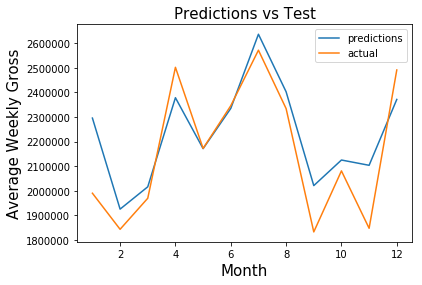

SARIMAX


/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency info

Final Table


,RMSE
Models,
"(SARIMA FROM GS, (0, 1, 1, 0, 1, 1, 12))",142336.508035
Baseline,148320.030940
"(SARIMAX , (1, 0, 0, 1, 0, 0, 12))",155432.396665
"(SARIMAX , (2, 0, 0, 2, 0, 0, 12))",181077.250615
"(SARIMAX , (2, 0, 1, 2, 0, 1, 12))",198658.566970
"(SARIMAX , (1, 0, 1, 1, 0, 1, 12))",203054.299219
"(SARIMAX , (0, 1, 0, 0, 1, 0, 12))",254553.334552
"(SARIMAX , (2, 1, 0, 2, 1, 0, 12))",307920.756150
"(SARIMAX , (1, 1, 0, 1, 1, 0, 12))",322009.181725


In [57]:
# Read in the df
df = pd.read_csv('gross.csv')
# Only get the rows and columns that we want
# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'The Lion King')]
# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
          'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
          'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 
# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)
# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]') 
# Step 5: set the df equal to df_month 
df_month = df
# Step 6: make date the index
df.set_index('date', inplace=True)
# Step 8: Downsampling to a month
df_month = df.resample('MS').mean()
#Step 9: Look at the final table
df_month.head()

# To show the scores of all the models throughout the notebook
scores = {}
# the test_start variable corresponds to the first date of the show, 
# which in this case means the beginning of our testing set
test_start = '1997-10-01'
test_end = '2018-12-01'

#### Baseline Model - AR

print('BASELINE')
baseline()

#### SARIMA Models - Parameter Selection

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            # print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])

print('SARIMA')
sarima(test_start, test_end, 0,1,1,0,1,1,12)

#### SARIMAX Model (with exogenous variables)

# Create a new df for the exog variables 
df_month_exog = df_month.copy()

df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)

# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

## add whether or not its December / Christmas month
df_month_exog['Xmas'] = ' '
df_month_exog['Xmas'] = np.where((df_month_exog['month'] == 12), 'Yes', df_month_exog['Xmas'])

## add whether or not it is Dec or Jan
df_month_exog['big_holiday'] = ' '
df_month_exog['big_holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['big_holiday'])

# Create dummies
dummies = ['season', 'month', 'holiday', 'big_holiday', 'Xmas']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )

# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')
    
# Building all the sarimax models
print('SARIMAX')
sarimax(test_start, test_end, 0,0,1, 0,0,1, 12)
sarimax(test_start, test_end, 0,1,0, 0,1,0, 12)
sarimax(test_start, test_end, 1,0,0, 1,0,0, 12)
sarimax(test_start, test_end, 1,0,1, 1,0,1, 12)
sarimax(test_start, test_end, 1,1,0, 1,1,0, 12)
sarimax(test_start, test_end, 2,0,0, 2,0,0, 12)
sarimax(test_start, test_end, 2,0,1, 2,0,1, 12)
sarimax(test_start, test_end, 2,1,0, 2,1,0, 12)

# Updating the list of all the models and their RMSE scores
print('Final Table')
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

## Evaluation
Throughout this project I used RMSE as my evaluation metric because it is a metric that tells us how far away our predicted values are from our actual values. It is commonly used and gives an average of how far off we are per month. In the case of Hamilton, the RMSE score tells us that our model is off by around $130,000 per month.  

## Conclusion
In conclusion, we can see that performing a grid search on a SARIMA model (no exogenous variables) gives us the best RMSE of all the other 50 plus models we tried. The order of variables for the Hamilton model is (1,1,0) and the seasonal order is (1,1,0,12). The final Hamilton model gives us an RMSE score of 131273. This means that in the year of 2019, our model was off on each month by its average weekly gross by $131,273. This model performs very well and can tell us whether we should invest in this Broadway show. 

## Future Improvements and Next Steps
When I continue this project, I will try to expand it by predicting on shows before they are even on Broadway. I will try to predict whether the show will make it to Broadway. This will be a classification problem. I can also solve this classification problem by using NLP to analyze articles that are written by Broadway show critics and see if the language that they use in the article will transfer to a successful or unsuccessful show. 